In [401]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
import jax.numpy as np
from jax import grad, jit, vmap, pmap
from jax import lax

In [402]:
t = np.arange(-4, 4, 0.01)

def softplus(x):
    return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0)

def mish(x): 
    return x * np.tanh(softplus(x))

def lisht(x): 
    return x * np.tanh(x)

def sgelu(x): 
    return x * lax.erf(x)

def jish(x, p_opt):
    return p_opt[0] * (-x * (x+ p_opt[1]) / (p_opt[2] + np.abs(x+p_opt[3])) - x + p_opt[4])

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def swish(x):
    return x * sigmoid(x)

def op(p_opt):
  r = jish(t, p_opt)
  r2 = mish(t)
  return mean_squared_error(r, r2)

In [403]:
x0 = [-0.5, 1., 0.5, 1., -0.5]
res = minimize(op, x0, method='nelder-mead',
               options={'xtol': 1e-8, 'disp': True})

p_best = list(np.round(res.x, 5)); p_best

Optimization terminated successfully.
         Current function value: 0.002535
         Iterations: 302
         Function evaluations: 555


[-0.55073, 0.62593, 0.6406, 0.94513, -0.0189]

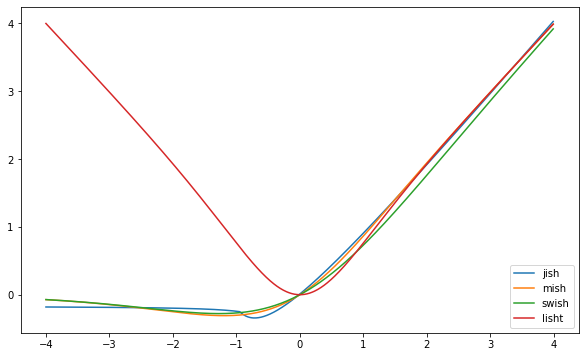

In [404]:
plt.figure(figsize=(10, 6))
plt.plot(t, jish(t, p_best))
plt.plot(t, mish(t))
plt.plot(t, swish(t))
plt.plot(t, lisht(t))
plt.legend(['jish', 'mish', 'swish', 'lisht']);

In [405]:
mish_grad_fun = jit(grad(mish))
mish_grad = jit(vmap(mish_grad_fun))
swish_grad_fun = jit(grad(swish))
swish_grad = jit(vmap(swish_grad_fun))
lisht_grad_fun = jit(grad(lisht))
lisht_grad = jit(vmap(lisht_grad_fun))
jish_grad_fun = jit(grad(jish))
jish_grad = jit(vmap(jish_grad_fun, (0, None), 0))

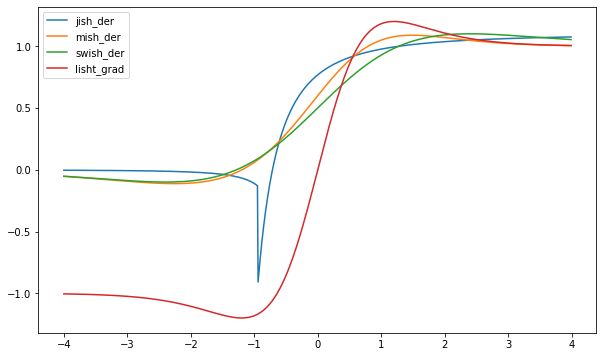

In [406]:
plt.figure(figsize=(10, 6))
plt.plot(t, jish_grad(t, p_best))
plt.plot(t, mish_grad(t))
plt.plot(t, swish_grad(t))
plt.plot(t, lisht_grad(t))
plt.legend(['jish_der', 'mish_der', 'swish_der', 'lisht_grad']);

In [407]:
def op_der_abs(p_temp):
  r = jish_grad(t, p_temp)
  r2 = mish_grad(t)
  return mean_absolute_error(r, r2)

res_abs = minimize(op_der_abs, p_best, method='nelder-mead',
               options={'xtol': 1e-8, 'disp': True})

p_der_abs = list(np.round(res_abs.x, 5))
print(p_der_abs)

Optimization terminated successfully.
         Current function value: 0.068248
         Iterations: 245
         Function evaluations: 468
[-0.53181, 0.23228, 0.62693, 0.24927, -0.02504]


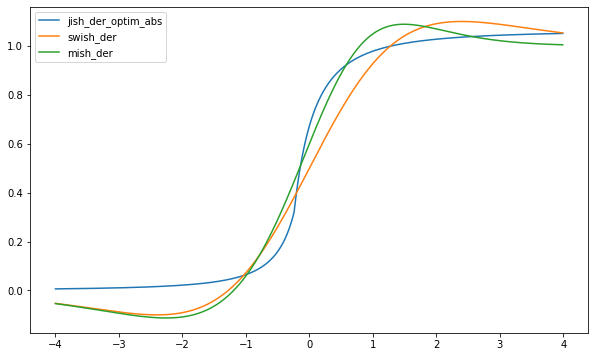

In [408]:
plt.figure(figsize=(10, 6))
plt.plot(t, jish_grad(t, p_der_abs))
plt.plot(t, swish_grad(t))
plt.plot(t, mish_grad(t))
plt.legend(['jish_der_optim_abs', 'swish_der', 'mish_der']);

In [409]:
m_temp = jit(grad(grad(mish)))
mish_grad2 = jit(vmap(m_temp))
s_temp = jit(grad(grad(swish)))
swish_grad2 = jit(vmap(s_temp))
l_temp = jit(grad(grad(lisht)))
lisht_grad2 = jit(vmap(l_temp))

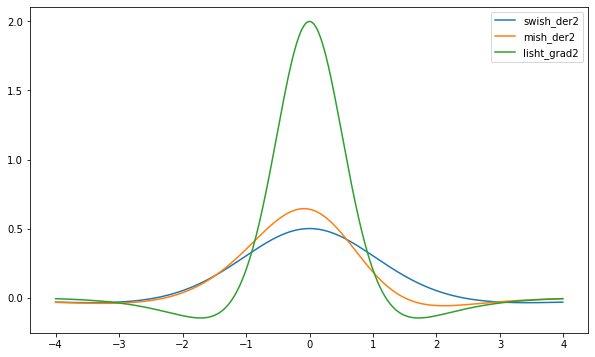

In [410]:
plt.figure(figsize=(10, 6))
plt.plot(t, swish_grad2(t))
plt.plot(t, mish_grad2(t))
plt.plot(t, lisht_grad2(t))
plt.legend(['swish_der2', 'mish_der2', 'lisht_grad2']);

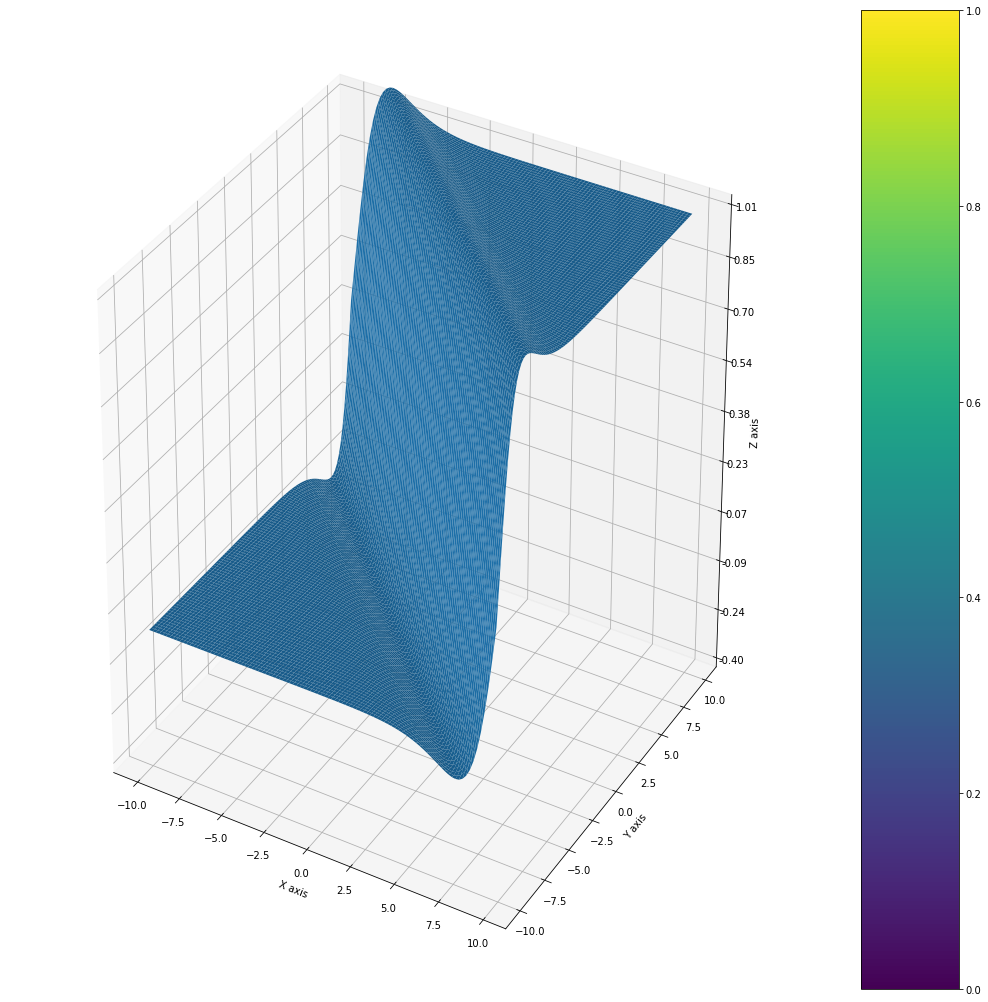

In [422]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


fig = plt.figure(figsize=(18, 18))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# Make data.
X = np.arange(-10, 10, 0.2)
Y = np.arange(-10, 10, 0.2)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
# R = X + Y
Z = vmap(vmap(grad(swish)))(R)


# Plot the surface.
surf1 = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, antialiased=True)

# Customize the z axis.
ax.set_zlim(-0.4, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf1, shrink=1.0, aspect=10)

### X.shape